In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('float_format', '{:.2f}'.format)
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=Warning)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime ,timedelta
from sklearn.metrics import mean_squared_error

# EDA

In [2]:
df = pd.read_excel('./ds.xlsx',sheet_name=1,parse_dates=['Date'],index_col='Date')
df

,Sales,Holiday,Event
Date,,,
2018-01-02,10036.00,Working_Day,No_Event
2018-01-03,9072.00,Working_Day,No_Event
2018-01-04,8927.00,Working_Day,No_Event
2018-01-05,8030.00,Working_Day,No_Event
2018-01-08,7644.00,Working_Day,No_Event
...,...,...,...
2021-06-24,5033.00,Working_Day,No_Event
2021-06-25,0.00,Holiday,No_Event
2021-06-28,8127.00,Working_Day,No_Event


In [3]:
df.info()

# We have 10 missing values in Sales column

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 912 entries, 2018-01-02 to 2021-06-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Sales    902 non-null    float64
 1   Holiday  912 non-null    object 
 2   Event    912 non-null    object 
dtypes: float64(1), object(2)
memory usage: 28.5+ KB


In [4]:
df.Holiday.value_counts()

Working_Day    875
Holiday         37
Name: Holiday, dtype: int64

In [5]:
df.Event.value_counts()

No_Event                          872
Blue Monday                         4
Easter Monday                       4
Walpurgis Night                     4
The Friday after Ascension Day      4
Valentine’s Day                     3
May Day                             3
Black Friday                        3
Cyber Monday                        3
Christmas Day                       3
New Year                            3
Halloween                           2
Saint Nicholas Day                  2
Singles Day                         2
Name: Event, dtype: int64

In [6]:
# Setting up dates frequency.

df.index = pd.DatetimeIndex(df.index.values,freq=pd.infer_freq(df.index.values))

In [7]:
df

,Sales,Holiday,Event
2018-01-02,10036.00,Working_Day,No_Event
2018-01-03,9072.00,Working_Day,No_Event
2018-01-04,8927.00,Working_Day,No_Event
2018-01-05,8030.00,Working_Day,No_Event
2018-01-08,7644.00,Working_Day,No_Event
...,...,...,...
2021-06-24,5033.00,Working_Day,No_Event
2021-06-25,0.00,Holiday,No_Event
2021-06-28,8127.00,Working_Day,No_Event
2021-06-29,7088.00,Working_Day,No_Event


In [8]:
df["new_col"] = df["Event"].apply(lambda x: "Event" if x != "No_Event" else x)

In [9]:
df.new_col.value_counts()

No_Event    872
Event        40
Name: new_col, dtype: int64

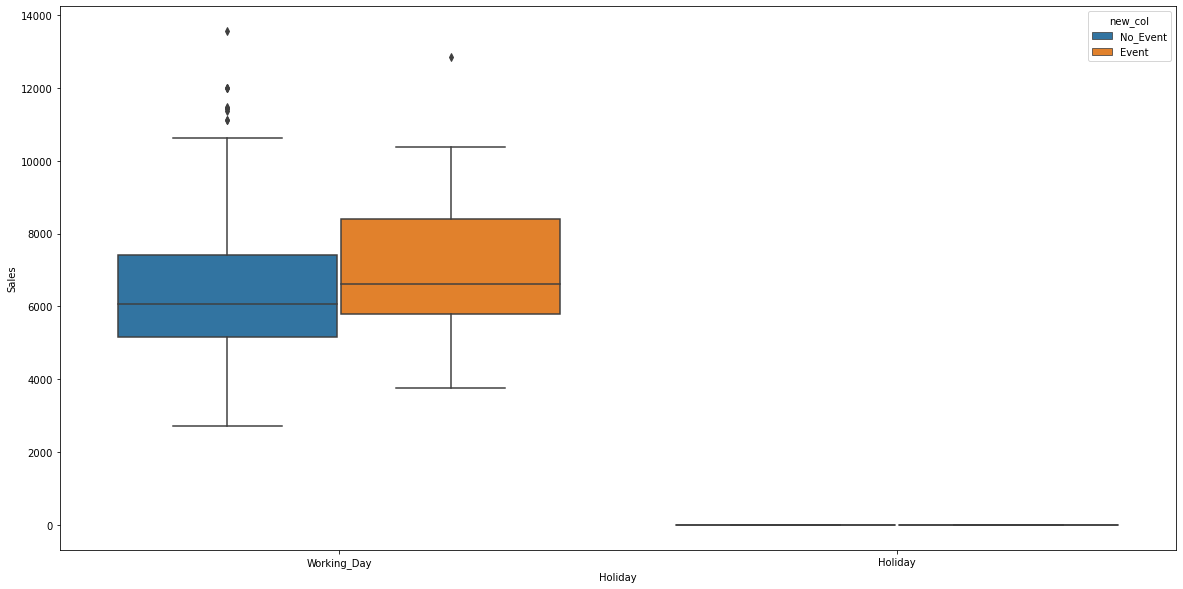

In [10]:
fig =plt.figure(figsize=(20,10))
sns.boxplot(x=df["Holiday"],y=df["Sales"],hue=df["new_col"]);

In [11]:
# On event days , sales seems to be higher than normal.
# There seeems to be some outlier as well from the plot.

<AxesSubplot:>

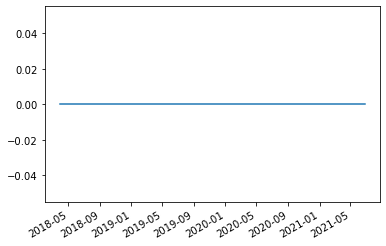

In [12]:
df.loc[df["Holiday"] == 'Holiday','Sales'].plot()

In [13]:
# On holidays sales are reported to be 0.There might be some sales on holiday but because its a holiday for reporting agency the data has not been captured.Might be,might not be 

In [14]:
df.drop('new_col',axis=1,inplace=True)

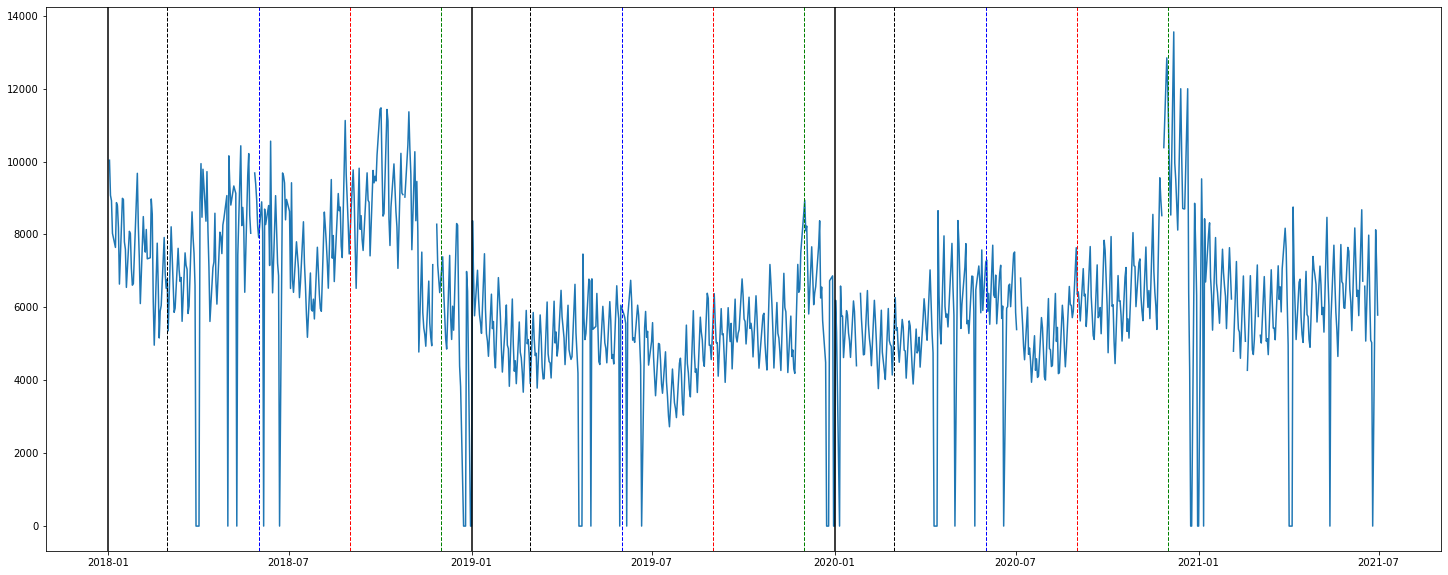

In [15]:
# Ploting raw time series of Sales.

fig = plt.figure(figsize=(25,10))
plt.plot(df.Sales);

for yr in range(2018,2021):
    plt.axvline(str(yr), color='k');
    plt.axvline(str(yr)+'-03-01', color='k', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-06-01', color='b', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-09-01', color='r', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-12-01', color='g', linestyle='--',linewidth = 1);

In [16]:
# There seems to be some seasonality .Trend is not obvious from the plot.Need furthur tests.

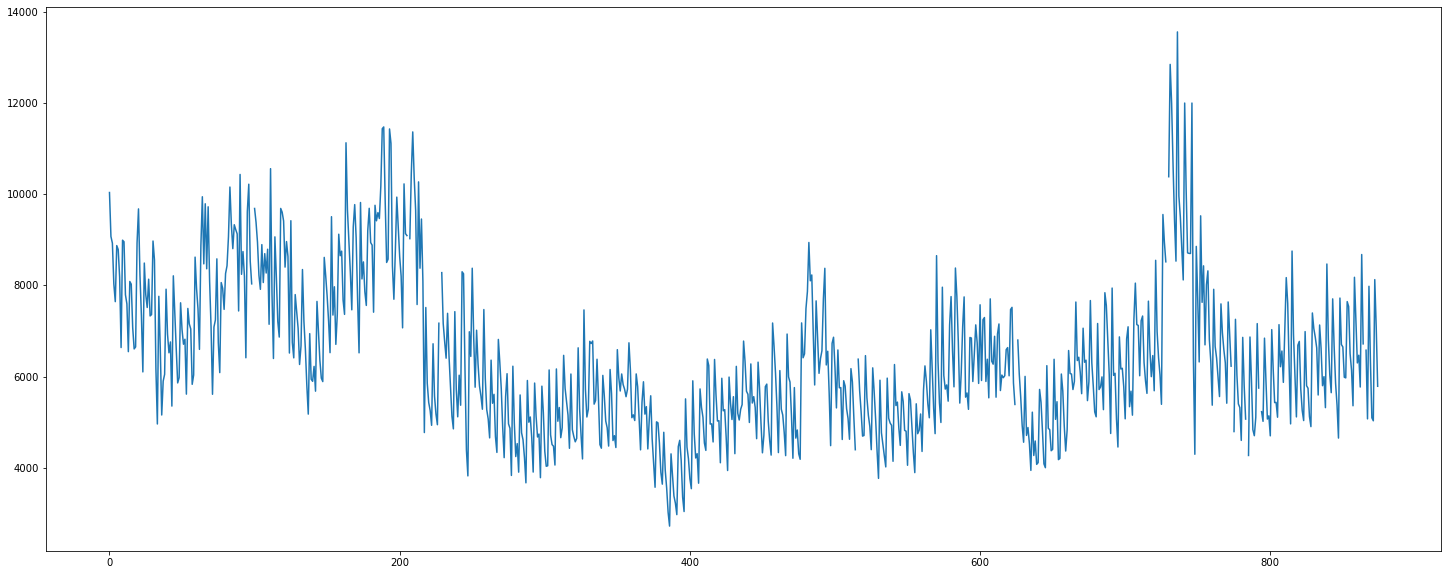

In [17]:
# Ploting data for working days.

fig = plt.figure(figsize=(25,10))
plt.plot(df.loc[df["Holiday"]=='Working_Day','Sales'].values)

In [18]:
# The points that were looking like outliers intitially were the 0 sales point for Holidays.

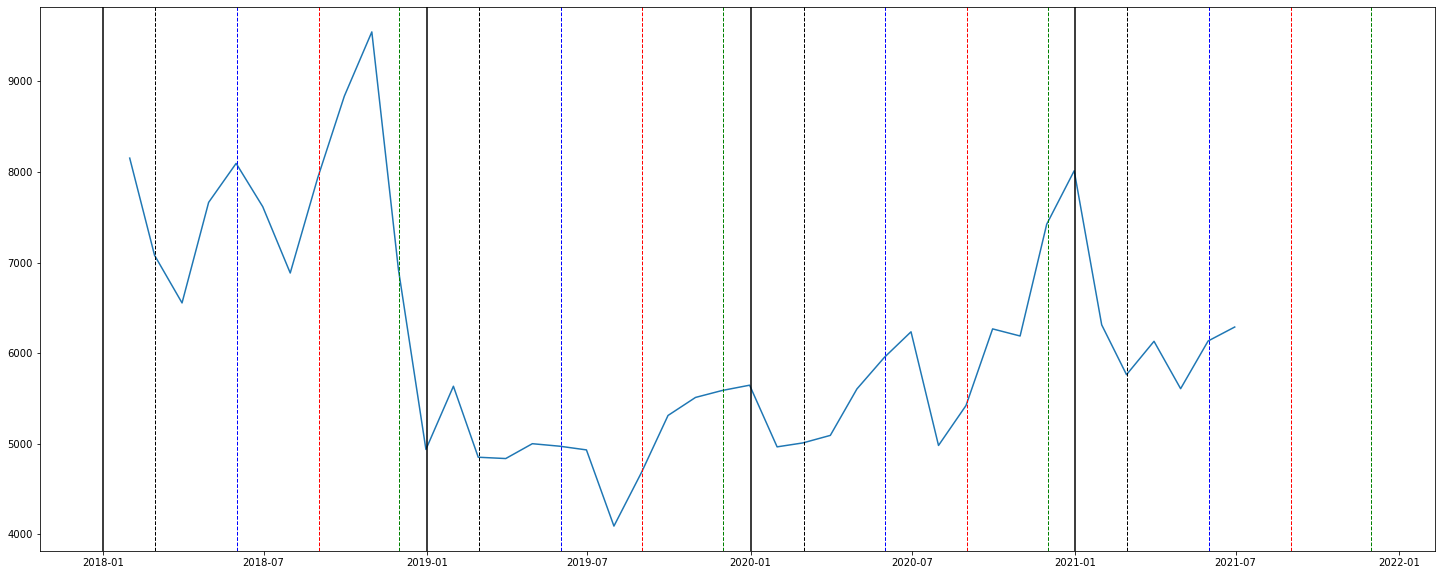

In [19]:
# Plotting monthly sampled data.

fig = plt.figure(figsize=(25,10))
plt.plot(df.resample('M').mean());

for yr in range(2018,2022):
    plt.axvline(str(yr), color='k');
    plt.axvline(str(yr)+'-03-01', color='k', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-06-01', color='b', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-09-01', color='r', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-12-01', color='g', linestyle='--',linewidth = 1);df.resample("M").mean()
    
# No abvious seasonality or trend can be seen.

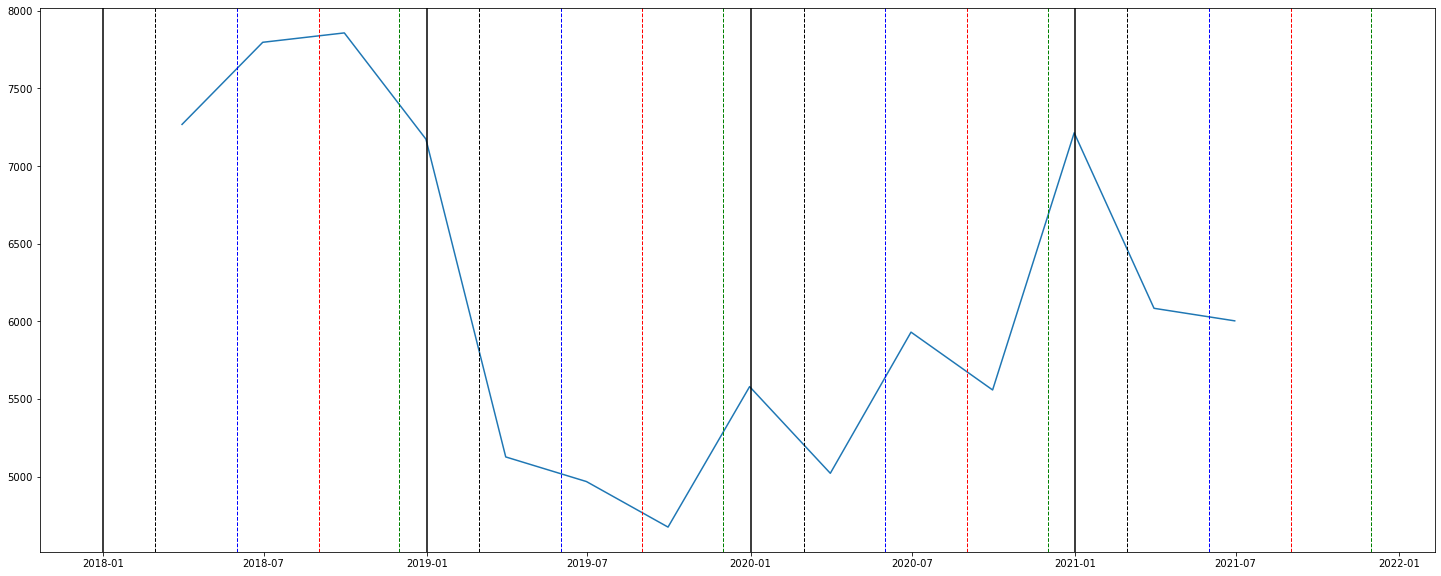

In [20]:
# Plotting Quaterly sampled data.

fig = plt.figure(figsize=(25,10))
plt.plot(df.resample('Q').mean());

for yr in range(2018,2022):
    plt.axvline(str(yr), color='k');
    plt.axvline(str(yr)+'-03-01', color='k', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-06-01', color='b', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-09-01', color='r', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-12-01', color='g', linestyle='--',linewidth = 1);df.resample("M").mean()

In [21]:
def ad_fuller_test(col):
    col.dropna(inplace=True)
    ans = adfuller(col)
    print(f"ADF stats : {ans[0]}")
    print(f"p-value : {ans[1]}\n")

In [22]:
def kpss_test(col):
    col.dropna(inplace=True)
    ans = kpss(col,regression='c')
    print(f"KPSS stats : {ans[0]}")
    print(f"p-value : {ans[1]}")

In [23]:
ad_fuller_test(df['Sales'])

# p-values < 0.05 implies series is stationary.

ADF stats : -3.196541471608893
p-value : 0.020185747261429753



In [24]:
kpss_test(df["Sales"])

KPSS stats : 1.0553203293350208
p-value : 0.01


C:\Users\adityg1\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [25]:
def plot_lag(col,lag):
    fig = plt.figure(figsize=(8,4))
    pd.plotting.lag_plot(col,lag=lag);
    plt.title(f"{lag}")

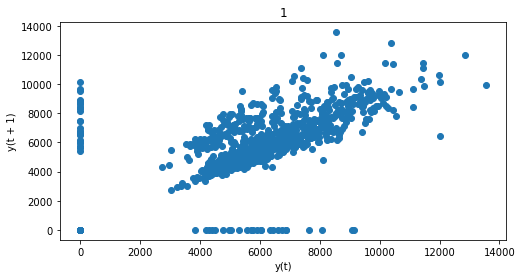

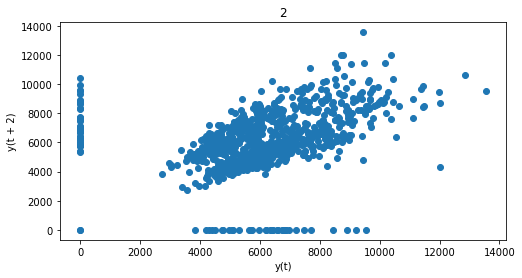

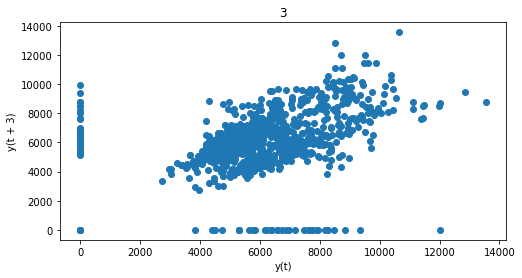

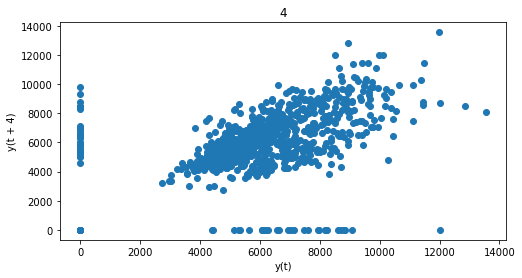

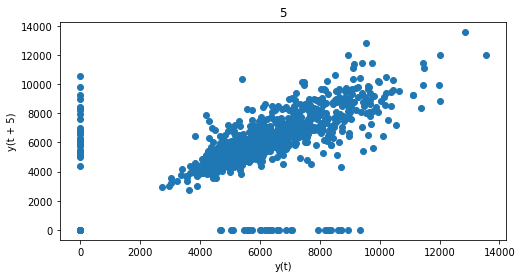

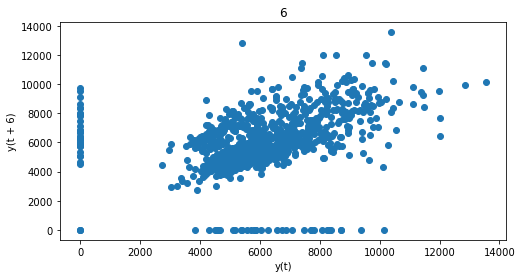

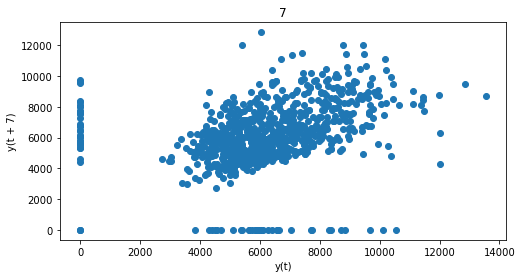

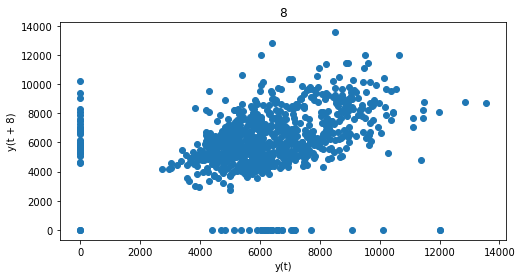

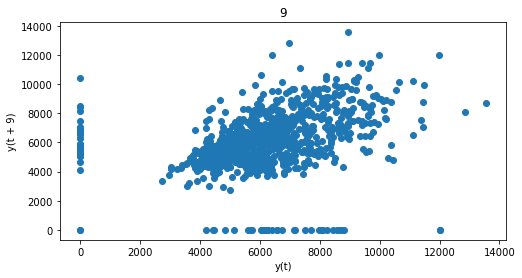

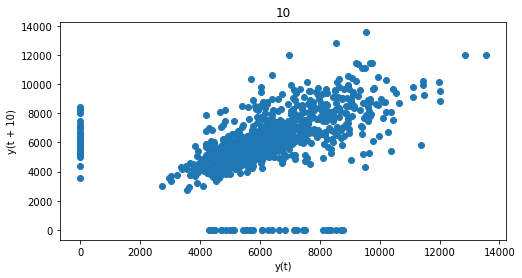

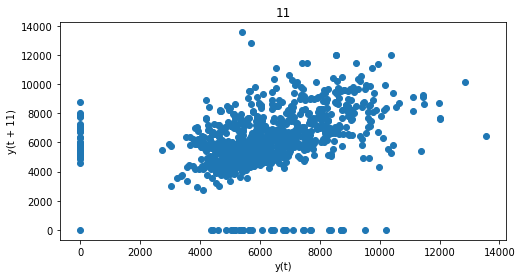

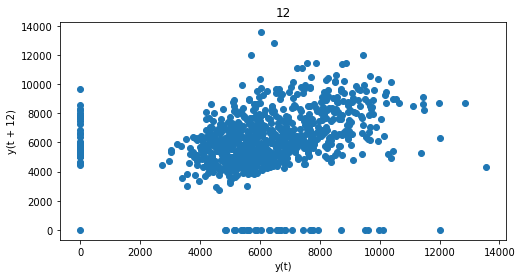

In [26]:
for i in range(1,13):
    plot_lag(df['Sales'],i)

In [27]:
# Lag 5 seems to be a bit linear than rest.

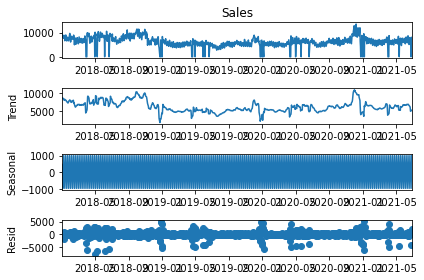

In [28]:
res = seasonal_decompose(df['Sales'].fillna(method='ffill'))
a = res.plot()

<AxesSubplot:>

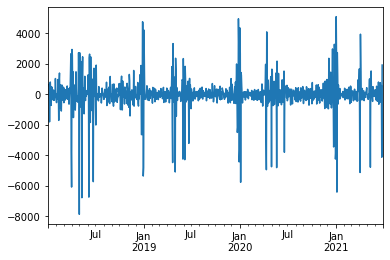

In [29]:
res.resid.plot()

In [30]:
ad_fuller_test(res.resid)

ADF stats : -12.439576781799147
p-value : 3.779695646733474e-23



In [31]:
def differencing(col,difference=1):
    col = col.diff(difference)
    col.dropna(inplace=True)
    return col

diff_series = differencing(df['Sales'],difference=1)

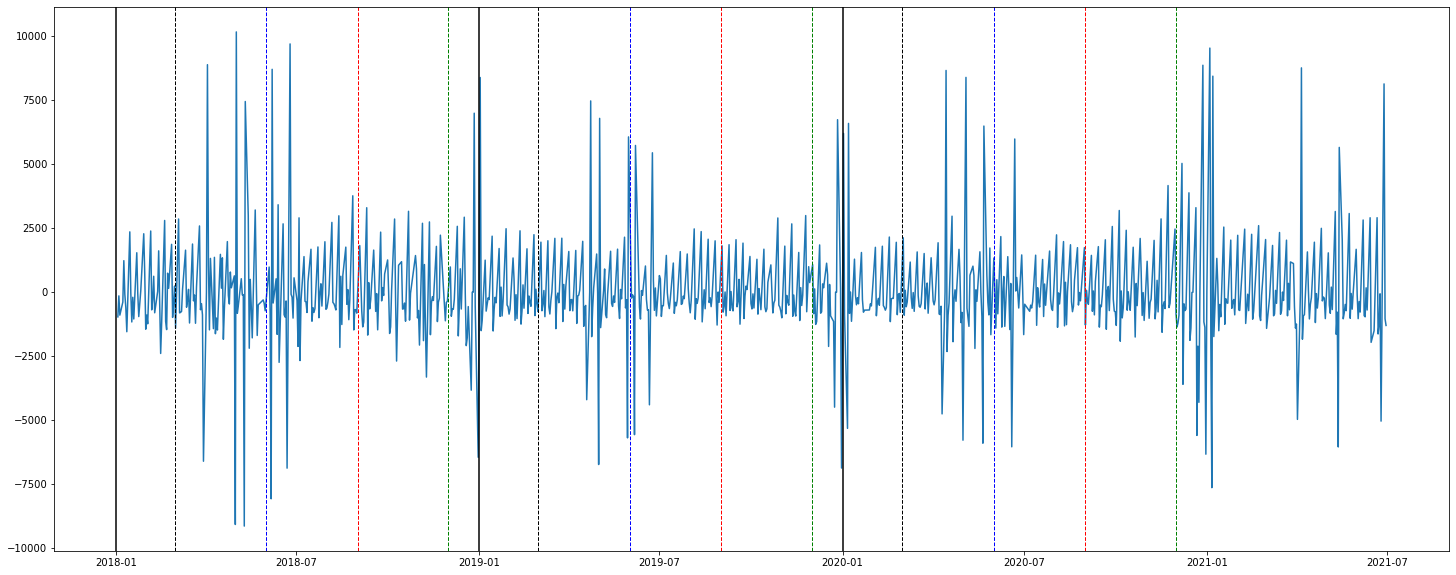

In [32]:
# Ploting differeced series of Sales.

fig = plt.figure(figsize=(25,10))
plt.plot(diff_series);

for yr in range(2018,2021):
    plt.axvline(str(yr), color='k');
    plt.axvline(str(yr)+'-03-01', color='k', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-06-01', color='b', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-09-01', color='r', linestyle='--',linewidth = 1);
    plt.axvline(str(yr)+'-12-01', color='g', linestyle='--',linewidth = 1);

In [33]:
ad_fuller_test(diff_series)

ADF stats : -9.060209753144779
p-value : 4.584812067739841e-15



In [34]:
# Differencing of 1 seems to make the series more stationary.We will let d parameter in SARIMA handle this .

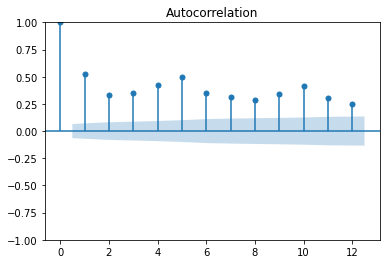

In [35]:
acf = plot_acf(df['Sales'].dropna(),lags=12)

# Significant lag at 1 shows , MA of order 1 is a good candidate.i.e , q = 1 in SARIMA.

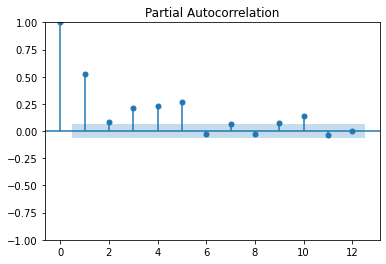

In [36]:
pcf = plot_pacf(df['Sales'].dropna(),lags=12)

# Significant lag at 1 shows , AR of order 1 are good candidate.i.e , p = 1 in SARIMA.

# Handling Missing values

In [37]:
miss_df = df.loc[df['Sales'].isna(),:]
miss_df

,Sales,Holiday,Event
2018-05-25,NaN,Working_Day,No_Event
2018-10-25,NaN,Working_Day,No_Event
2018-11-26,NaN,Working_Day,Cyber Monday
2020-01-24,NaN,Working_Day,No_Event
2020-07-03,NaN,Working_Day,No_Event
2020-11-26,NaN,Working_Day,No_Event
2021-02-04,NaN,Working_Day,No_Event
2021-02-18,NaN,Working_Day,No_Event
2021-03-03,NaN,Working_Day,No_Event
2021-06-16,NaN,Working_Day,No_Event


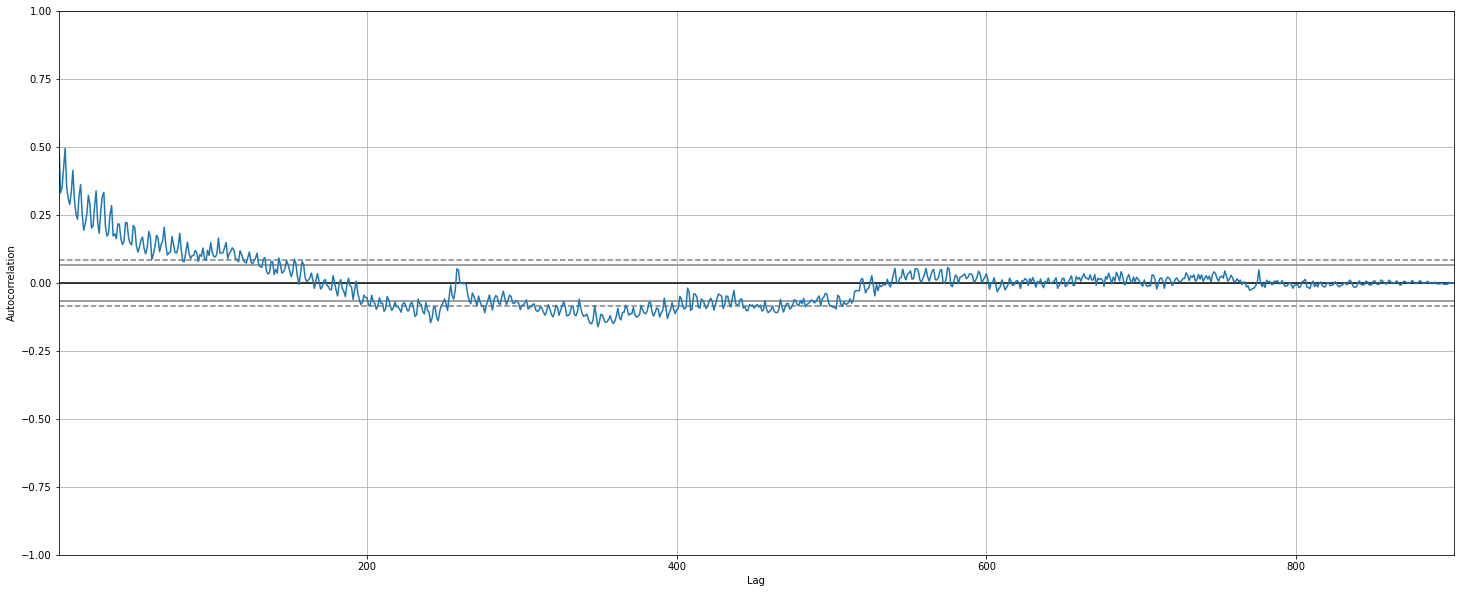

In [38]:
fig = plt.figure(figsize=(25,10))
pd.plotting.autocorrelation_plot(df["Sales"].dropna());

In [39]:
miss_df.index.day_name()

Index(['Friday', 'Thursday', 'Monday', 'Friday', 'Friday', 'Thursday',
       'Thursday', 'Thursday', 'Wednesday', 'Wednesday'],
      dtype='object')

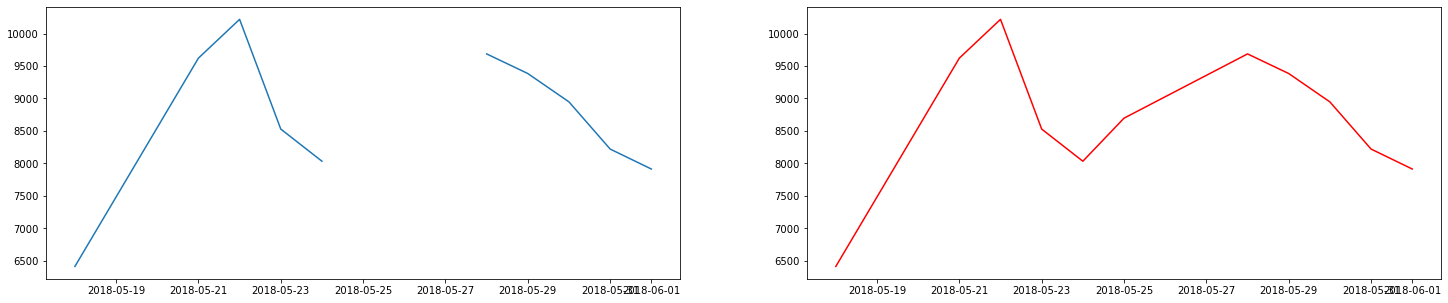

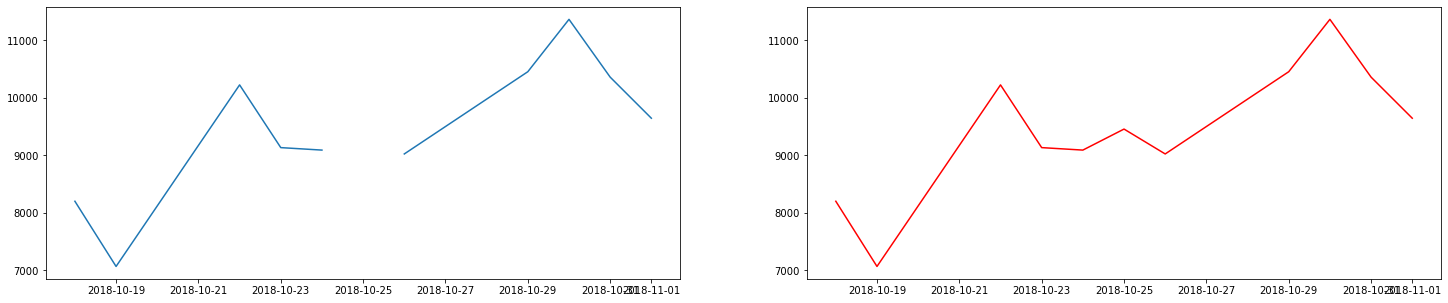

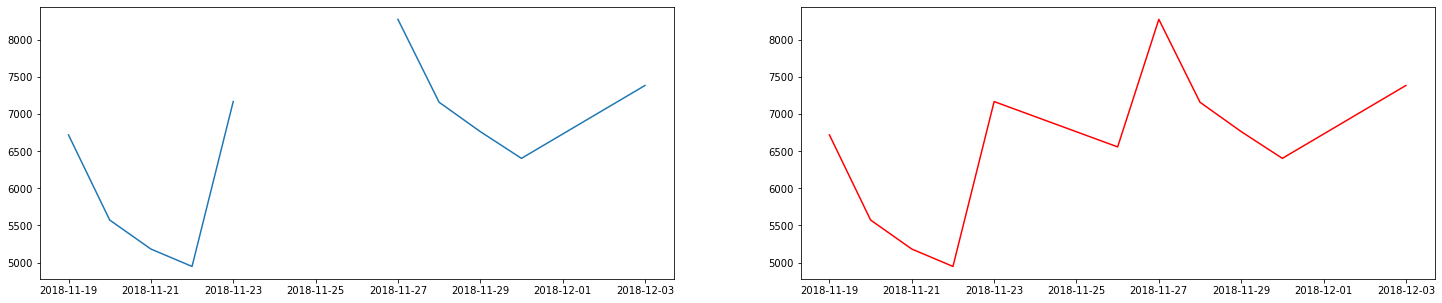

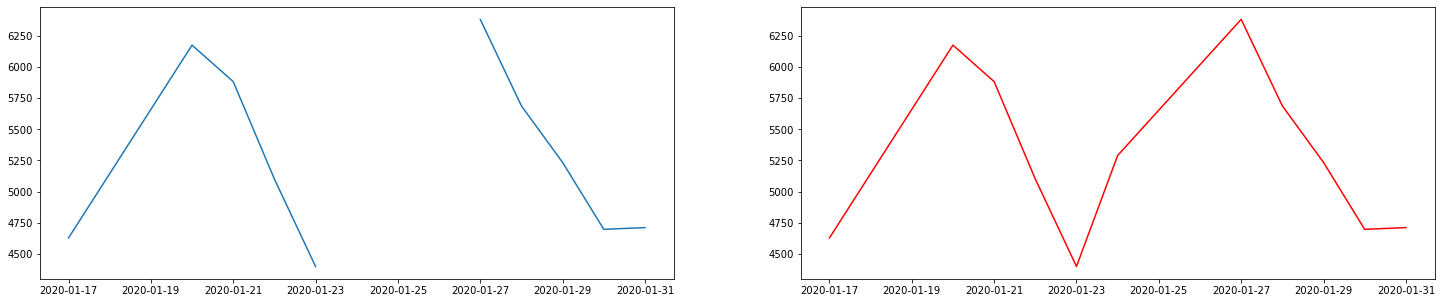

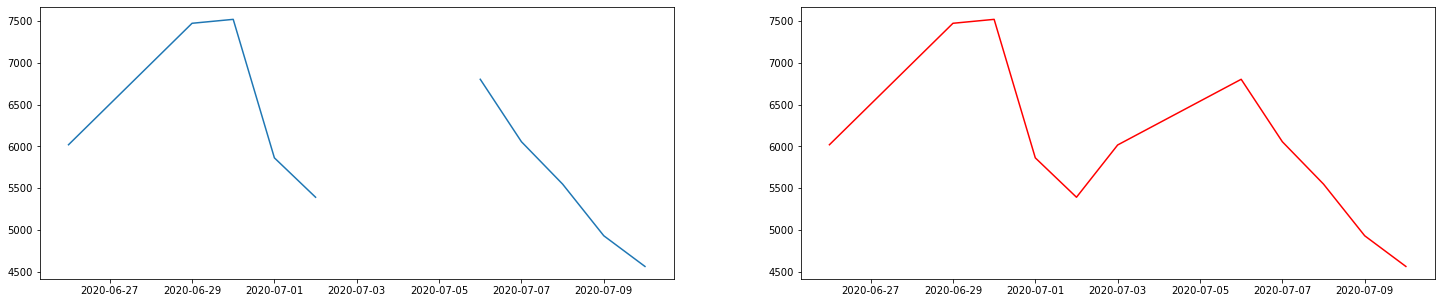

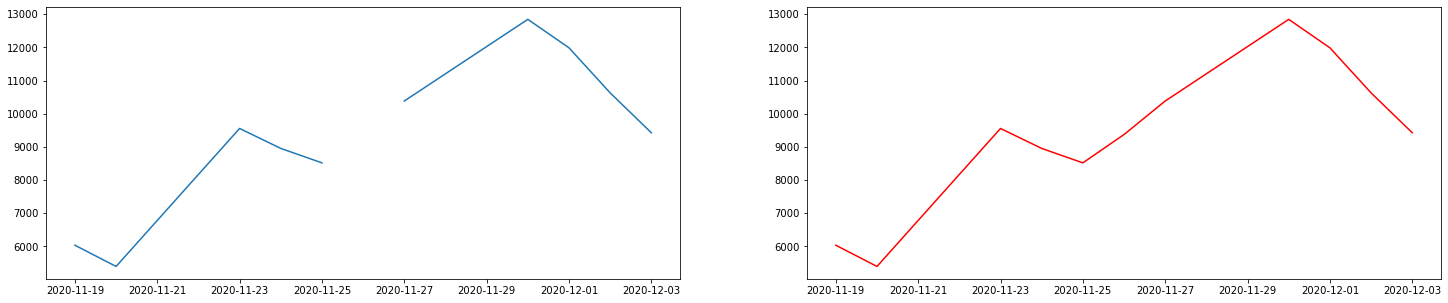

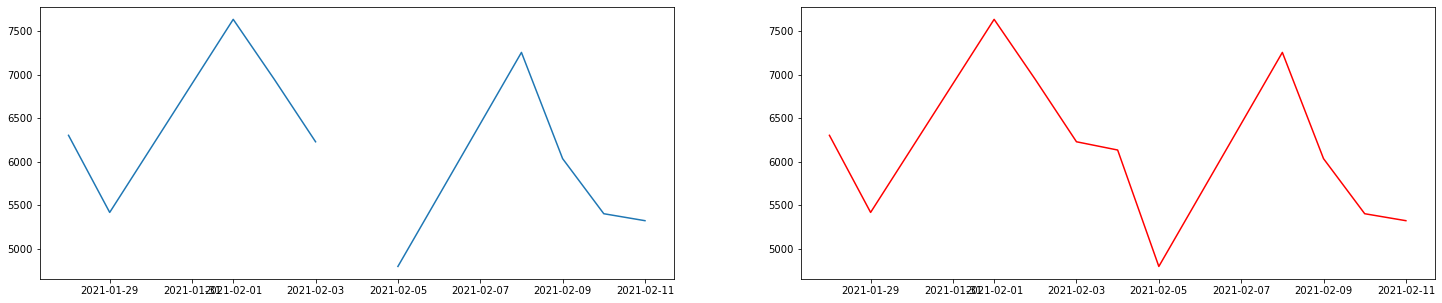

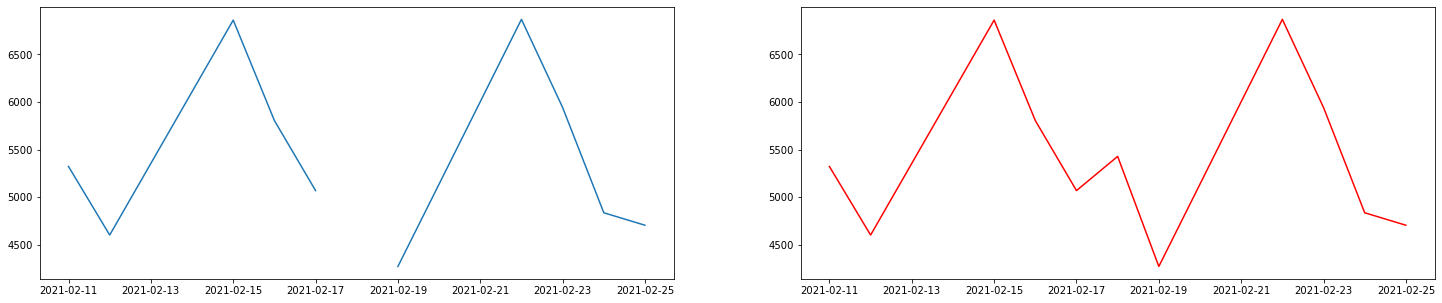

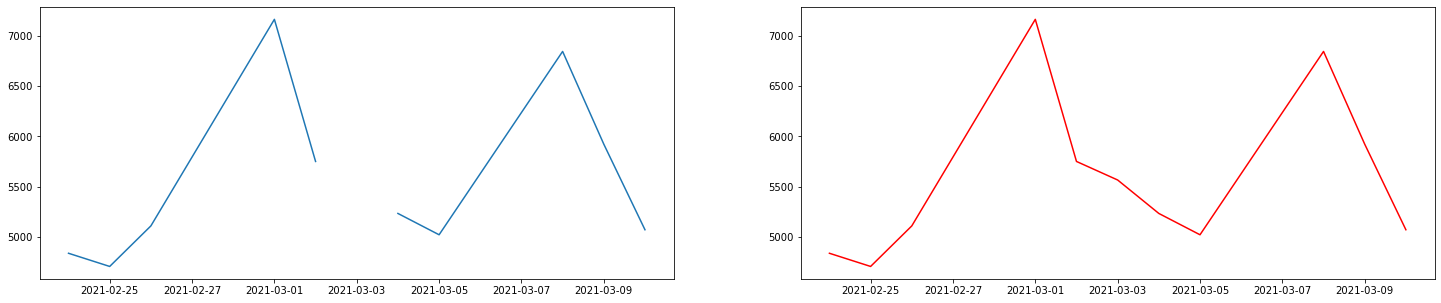

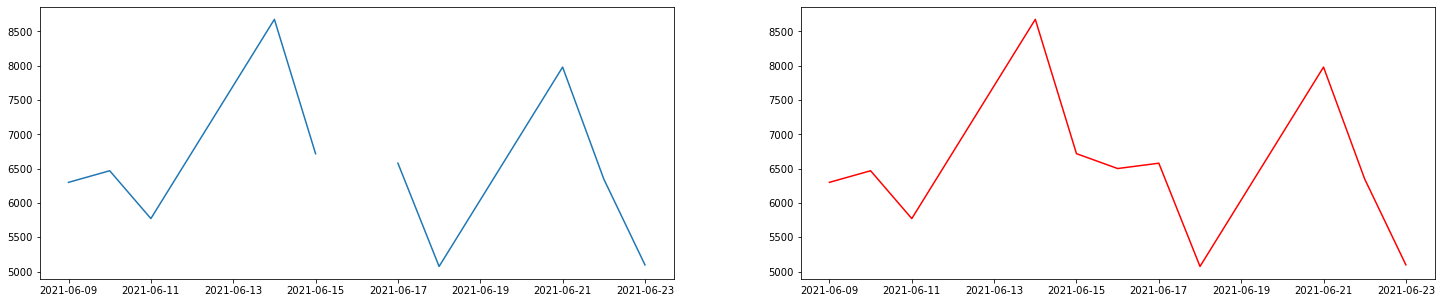

In [40]:
# Taking 5 days pre and post of missing dates and plotting to find some pattern (left side of the plot figure).

# There seems to be some pattern in the plots, so taking mean of the series and imputing the missing values and trying to plot on the right side.

for date in miss_df.index:
    fig,((fig1,fig2)) = plt.subplots(1,2,figsize=(25,5))
    temp_series = df.loc[date-timedelta(days=7) : date+timedelta(days=7) , "Sales"]  
    fig1.plot(temp_series);
    temp_series[date] = temp_series.mean()
    miss_df.loc[date,'Sales'] = temp_series.mean()
    df.loc[date,'Sales'] = temp_series.mean()
    fig2.plot(temp_series,color='r')

miss_df = miss_df.reset_index().iloc[:,[0,1]]
miss_df.columns = ["Date","Sales"]    
miss_df.to_excel("./Missing_value_imputation_result.xlsx",index=False)    

In [41]:
miss_df = miss_df.reset_index().iloc[:,[0,1]]
miss_df.columns = ["Date","Sales"]

# Model Building

In [42]:
from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.37. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [43]:
df.Holiday.value_counts()

Working_Day    875
Holiday         37
Name: Holiday, dtype: int64

In [44]:
df.Event.value_counts()

No_Event                          872
Blue Monday                         4
Easter Monday                       4
Walpurgis Night                     4
The Friday after Ascension Day      4
Valentine’s Day                     3
May Day                             3
Black Friday                        3
Cyber Monday                        3
Christmas Day                       3
New Year                            3
Halloween                           2
Saint Nicholas Day                  2
Singles Day                         2
Name: Event, dtype: int64

In [45]:
# Encoding No_Event to 1 and rest all events to 0.

df['Event'] = df['Event'].apply(lambda x : 1 if x=="No_Event" else 0)

In [46]:
# Emcoding Working_days to 1 and Holidays to 0.

df['Holiday'] = df['Holiday'].apply(lambda x : 1 if x=="Working_Day" else 0)

In [47]:
df.reset_index(inplace=True)

In [48]:
train_size = 0.90

df_train = df.loc[:int(np.round(train_size*len(df))),:]
df_test = df.loc[~df.index.isin(df_train.index),:]

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -3.818365645536283      |
|           p-value           |    0.0027249018384925424     |
|          #Lags Used         |             9.0              |
| Number of Observations Used |            812.0             |
|     Critical Value (1%)     |     -3.4384289321263126      |
|     Critical Value (5%)     |      -2.865105979079729      |
|     Critical Value (10%)    |      -2.568668841575869      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = Sales
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_col

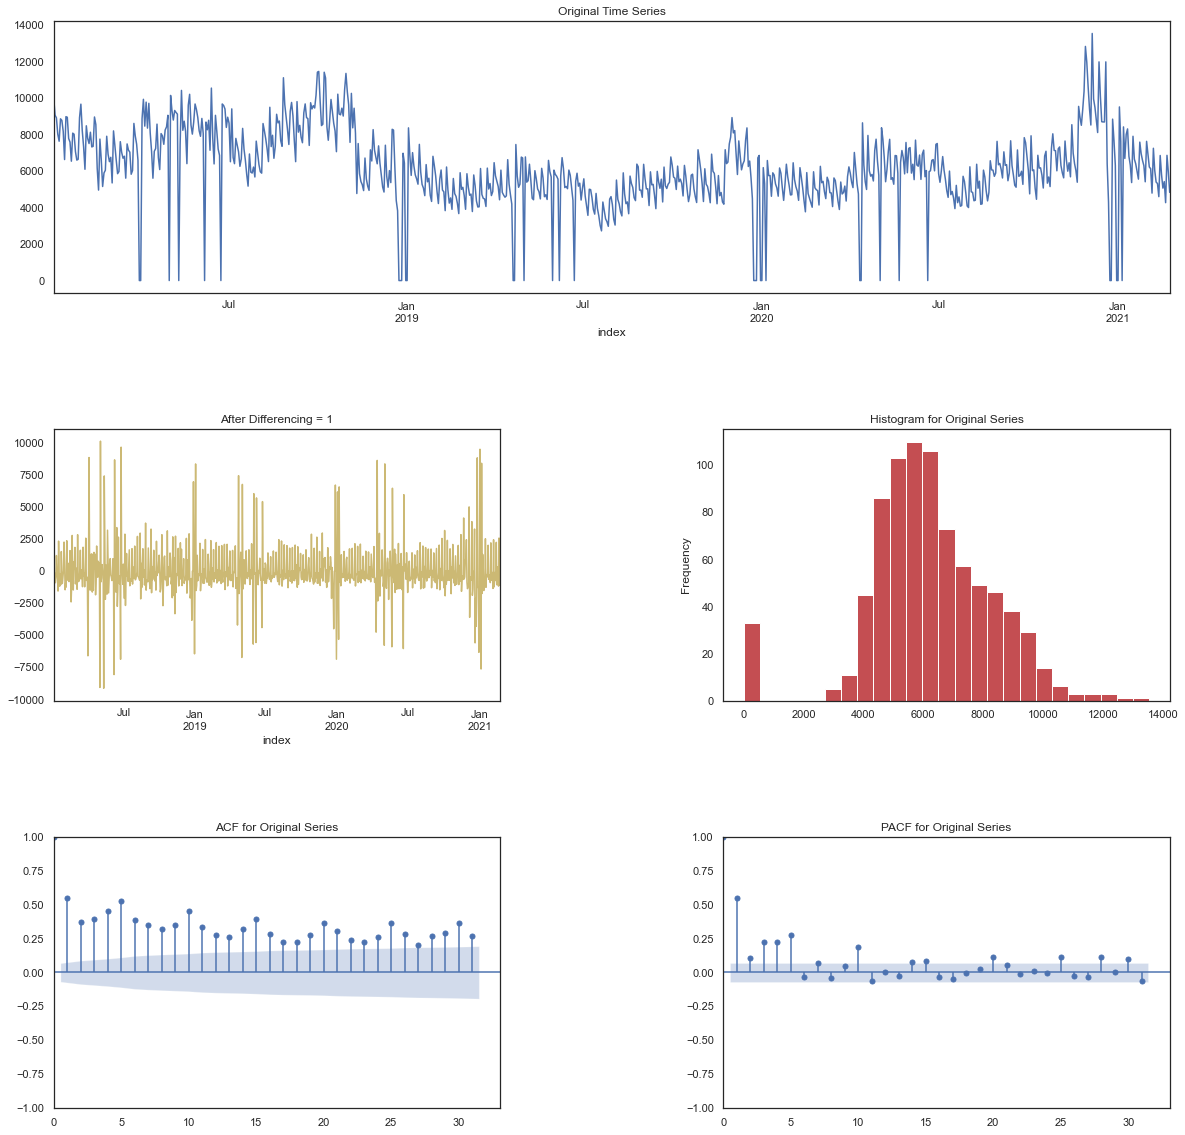

Time Interval is given as B
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(822, 4)) with Confidence Interval = 0.95...
  Starting Prophet Fit
       Adding daily seasonality to Prophet with period=12, fourier_order=15 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 2

Fold Number: 1 --> Train Shape: 812 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 423.71
    Std Deviation of actuals = 769.61
    Normalized RMSE = 55%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 817 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 587.53
    Std Deviation of actuals = 896.23
    Normalized RMSE = 66%
Cross Validation window: 2 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
  

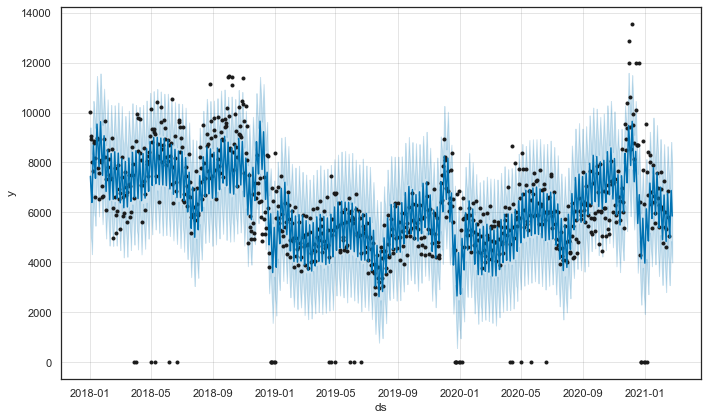

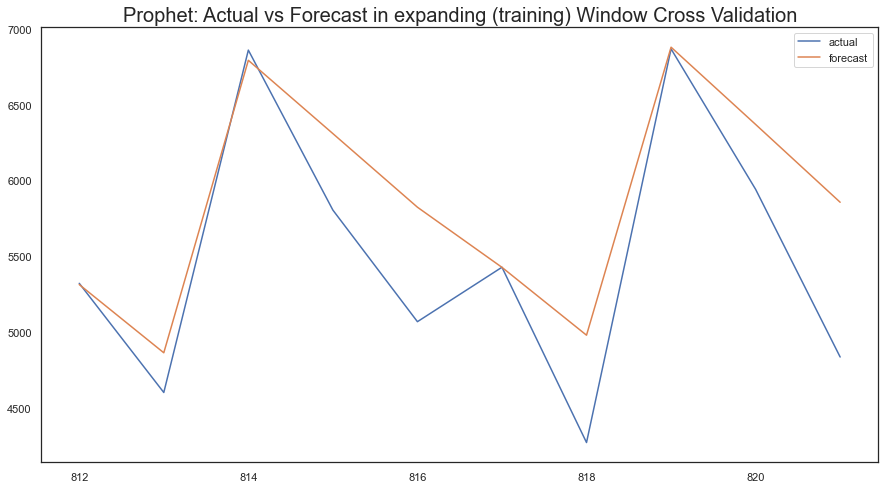

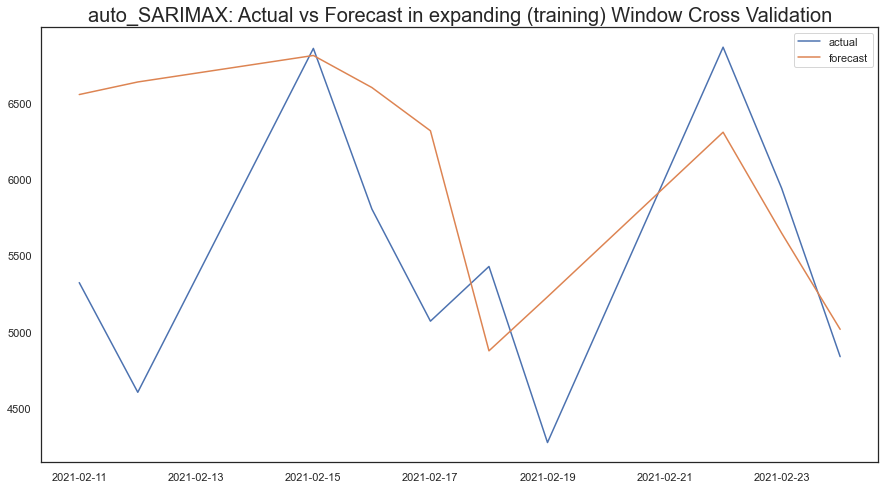

In [49]:
# Fitting FB Prophet and SARIMA model with max p,d,q set to 4.2.4 .

model = auto_timeseries(score_type='rmse',time_interval='B',seasonality=True,model_type=['prophet','ARIMA'],non_seasonal_pdq=(3,2,3),verbose=2,conf_int=0.95)
    
model.fit(traindata = df_train,ts_column='index',target='Sales',cv=2)

In [50]:
model.get_leaderboard()

,name,rmse
0,Prophet,505.62
1,auto_SARIMAX,915.14


In [51]:
def model_comparision(df,col,test_model):
    predicted = model.predict(testdata=df,model=test_model)['yhat']
    fig = plt.figure(figsize=(20,7))
    ax = plt.plot(df['index'].values,df[col].values);
    ax2 = plt.plot(df['index'].values,predicted.values,color='r',linewidth=2);
    plt.legend(("Actual","Predicted"));
    error = np.sqrt(mean_squared_error(df[col].values,predicted.values))
    plt.title(f"Actual vs Predicted on test data by model : {test_model} with RMSE of {error:.2f}");

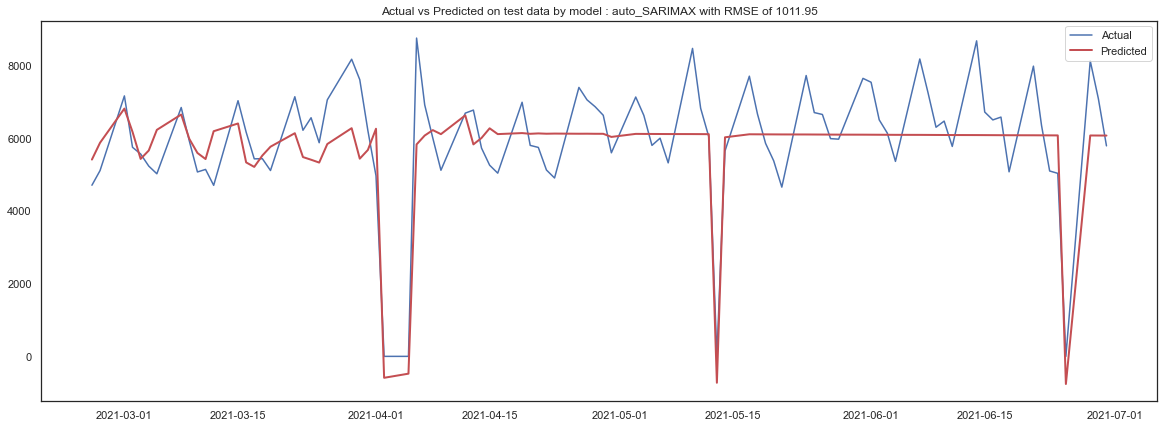

In [52]:
model_comparision(df_test,'Sales',test_model='auto_SARIMAX')

Building Forecast dataframe. Forecast Period = 90


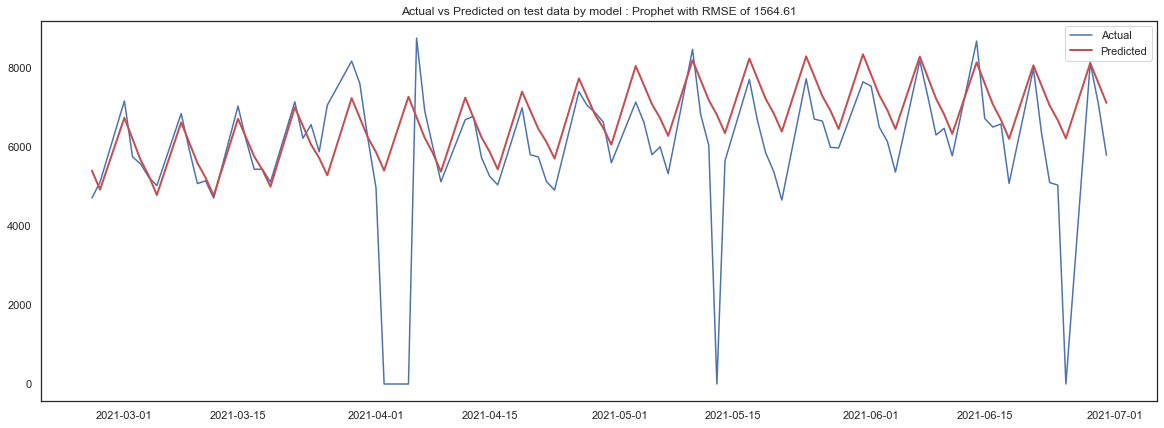

In [53]:
model_comparision(df_test,'Sales',test_model='Prophet')

# Trying Ensembles of models

In [54]:
prediction_sarima = model.predict(testdata=df_test , model='auto_SARIMAX')['yhat'].values
prediction_prophet = model.predict(testdata=df_test , model='Prophet')['yhat'].values

ensemled_prediction = (2*prediction_sarima + prediction_prophet)/3

Building Forecast dataframe. Forecast Period = 90


In [55]:
ensemled_prediction

array([5408.08145455, 5555.86935779, 6788.27354559, 6183.77440809,
       5509.86349838, 5530.65049818, 5746.87602915, 6640.64930518,
       6021.03295153, 5593.0520122 , 5358.49832682, 5716.30731665,
       6506.77235121, 5633.23884502, 5392.57148035, 5489.20620602,
       5508.04208085, 6424.71625709, 5830.5647078 , 5624.49555901,
       5459.10012895, 5653.41387406, 6594.96693714, 5870.38245949,
       5863.24780946, 6128.91155303, 1407.29450872, 2105.30812254,
       6135.26860888, 6125.17701295, 6096.69388718, 5864.64227918,
       6833.95416228, 6133.38235566, 6083.63640772, 6140.84544206,
       5885.06938114, 6559.51891916, 6388.70752981, 6239.54957434,
       6123.49129857, 5985.82249025, 6659.12178294, 6505.93357398,
       6350.13301147, 6240.25445961, 6041.69000331, 6761.2230602 ,
       6600.01890312, 6437.75649   , 6319.20634037, 6168.72247169,
       6806.49969934, 6637.76195774, 6468.40117092, 1786.76742291,
       6131.87624645, 6816.35777015, 6646.42778106, 6476.77094

868.3574655147534


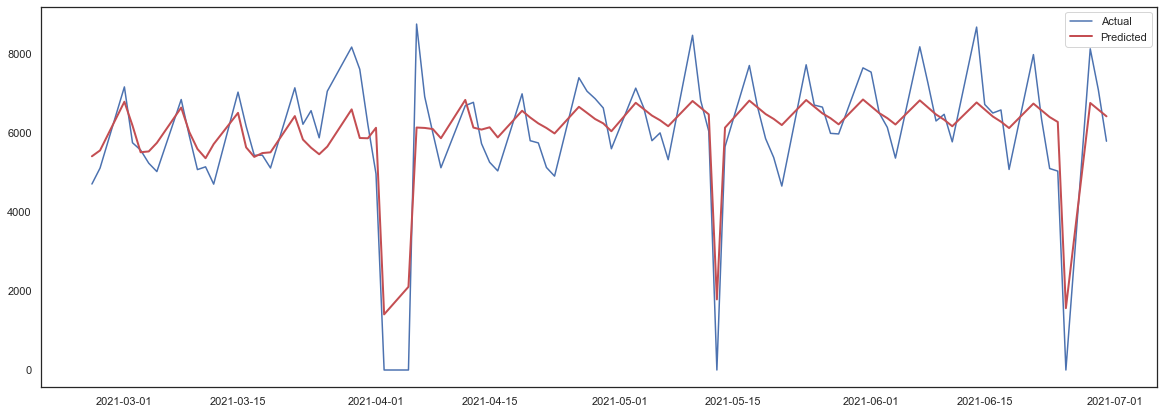

In [56]:
# Plotting ensembled result wrt actuals

fig = plt.figure(figsize=(20,7))
ax = plt.plot(df_test['index'].values,df_test['Sales'].values);
ax2 = plt.plot(df_test['index'].values,ensemled_prediction,color='r',linewidth=2);
plt.legend(("Actual","Predicted"));
error = np.sqrt(mean_squared_error(df_test['Sales'].values,ensemled_prediction))
print(error)

# Trying Prophet model with Holidays as parameter

In [57]:
# Seems like Prophet is able to capture the trend and seasonality very well even though the RMSE is higher compared to Sarima.Holiday parts was captured well by SARIMA.Prophet can be tunned even furthur by providing holiday as a parameter .

In [58]:
from fbprophet import Prophet

In [59]:
holidays = df_train.query('Holiday==0')[['index','Holiday']]
holidays.columns=['ds','holiday']
holidays['holiday']='noworkday'
holidays

,ds,holiday
63,2018-03-30,noworkday
64,2018-04-02,noworkday
85,2018-05-01,noworkday
92,2018-05-10,noworkday
111,2018-06-06,noworkday
123,2018-06-22,noworkday
254,2018-12-24,noworkday
255,2018-12-25,noworkday
256,2018-12-26,noworkday
259,2018-12-31,noworkday


In [60]:
# Will all other parameters as default and only provide Holiday.

model_prophet = Prophet(holidays=holidays)

In [61]:
df_train.rename(columns={'index':'ds','Sales':'y'},inplace=True)
df_test.rename(columns={'index':'ds','Sales':'y'},inplace=True)

In [62]:
fitted_model = model_prophet.fit(df_train)

In [63]:
predicted_value = fitted_model.predict(df=df_test)['yhat']

1901.9163971184607


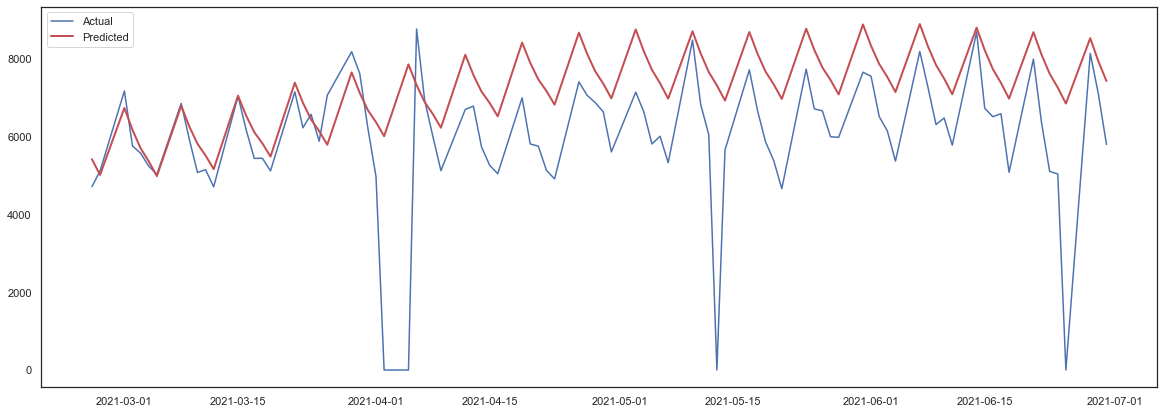

In [64]:
fig = plt.figure(figsize=(20,7))
ax = plt.plot(df_test['ds'].values,df_test['y'].values);
ax2 = plt.plot(df_test['ds'].values,predicted_value.values,color='r',linewidth=2);
plt.legend(("Actual","Predicted"));
error = np.sqrt(mean_squared_error(df_test['y'].values,predicted_value.values))
print(error)

### As prophet model with holidays has not performed any better than the one built using auto_ts,we will go ahead and choose Prophet model as our final model.

In [65]:
# Fitting Prophet model to whole dataset and predicting for next 3 months.

df.rename(columns={'index':'ds','Sales':'y'},inplace=True)
df.rename(columns={'index':'ds','Sales':'y'},inplace=True)

In [66]:
model = Prophet()
final_model = model.fit(df)

In [67]:
future_df = final_model.make_future_dataframe(periods=92)

In [68]:
predicted_value = fitted_model.predict(df=future_df)



RMSE of final model is 1060.25




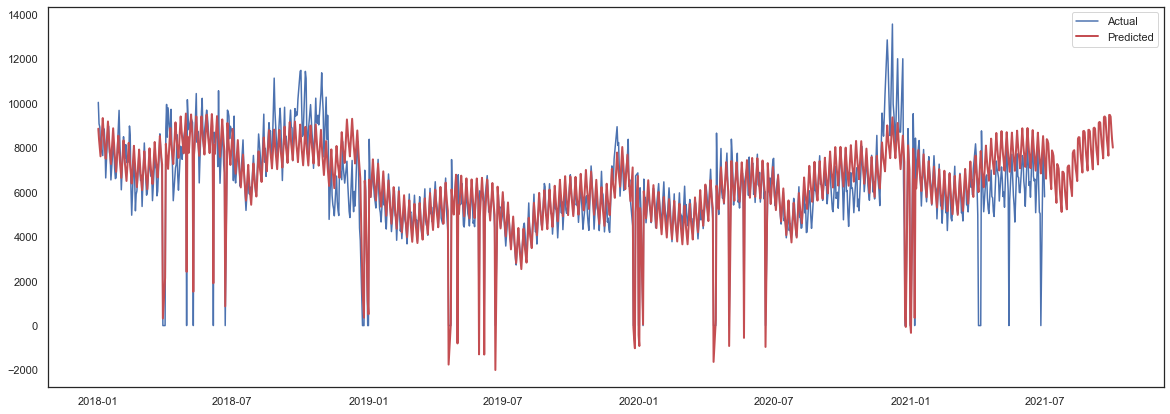

In [69]:
fig = plt.figure(figsize=(20,7))
ax = plt.plot(df['ds'].values,df['y'].values);
ax2 = plt.plot(future_df['ds'],predicted_value['yhat'].values,color='r',linewidth=2);
plt.legend(("Actual","Predicted"));
error = np.sqrt(mean_squared_error(df['y'].values,predicted_value['yhat'][:-92].values))
print(f"\n\nRMSE of final model is {error:.2f}\n\n")

In [70]:
# Prophet model was able to model our time series pretty good with some miss at highs and lows with a RMSE of 1060..

In [71]:
final_predicted_df = predicted_value[['ds','yhat']][-92:]
final_predicted_df.columns = ["Date","Sales"]
final_predicted_df

,Date,Sales
912,2021-07-01,7039.81
913,2021-07-02,6604.96
914,2021-07-03,8381.77
915,2021-07-04,8324.67
916,2021-07-05,8189.97
...,...,...
999,2021-09-26,9468.40
1000,2021-09-27,9391.63
1001,2021-09-28,8824.85
1002,2021-09-29,8345.68


In [72]:
final_predicted_df['weekday'] = final_predicted_df['Date'].dt.day_name()

In [73]:
# Mapping Saturday and Sunday sales value to 0 

final_predicted_df["Sales"] = final_predicted_df.apply(lambda x : 0 if x['weekday'] == 'Saturday' or x['weekday'] == 'Sunday' else x['Sales'],axis=1)
final_predicted_df.drop('weekday',axis=1,inplace=True)

In [74]:
final_predicted_df

,Date,Sales
912,2021-07-01,7039.81
913,2021-07-02,6604.96
914,2021-07-03,0.00
915,2021-07-04,0.00
916,2021-07-05,8189.97
...,...,...
999,2021-09-26,0.00
1000,2021-09-27,9391.63
1001,2021-09-28,8824.85
1002,2021-09-29,8345.68


In [75]:
final_predicted_df.to_excel("./3 months prediction_result.xlsx",index=False)